Downloading/Preparing TFDS cats_vs_dogs...
CPU cores: 12, GPU: True, /dev/shm ≈ 40.75082015991211 GB
Auto-selected num_workers = 4

=== Summary: ResNet-34 ===
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
        

/tmp/ipython-input-3583741042.py:269: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


[01] train 0.9662/0.546 | val 0.7381/0.518
[02] train 0.6582/0.616 | val 0.6279/0.648
[03] train 0.6168/0.664 | val 0.5868/0.684
[04] train 0.5868/0.688 | val 0.5955/0.690
[05] train 0.5660/0.707 | val 0.5650/0.701
[06] train 0.5433/0.729 | val 0.5849/0.695
[07] train 0.5091/0.750 | val 0.5626/0.737
[08] train 0.4757/0.772 | val 0.5478/0.742
[09] train 0.4335/0.799 | val 0.5125/0.760
[10] train 0.4030/0.816 | val 0.4239/0.804
[11] train 0.3702/0.836 | val 0.3822/0.830
[12] train 0.3440/0.848 | val 0.3725/0.832
[13] train 0.3102/0.867 | val 0.3819/0.827
[14] train 0.2839/0.879 | val 0.3704/0.835
[15] train 0.2582/0.892 | val 0.3525/0.840
[16] train 0.2270/0.902 | val 0.3416/0.863
[17] train 0.2107/0.910 | val 0.3318/0.859
[18] train 0.1840/0.926 | val 0.5225/0.789
[19] train 0.1581/0.936 | val 0.2917/0.876
[20] train 0.1399/0.943 | val 0.2766/0.891
[21] train 0.1281/0.949 | val 0.4025/0.845
[22] train 0.1050/0.958 | val 0.3360/0.881
[23] train 0.0926/0.963 | val 0.3478/0.884
[24] train 

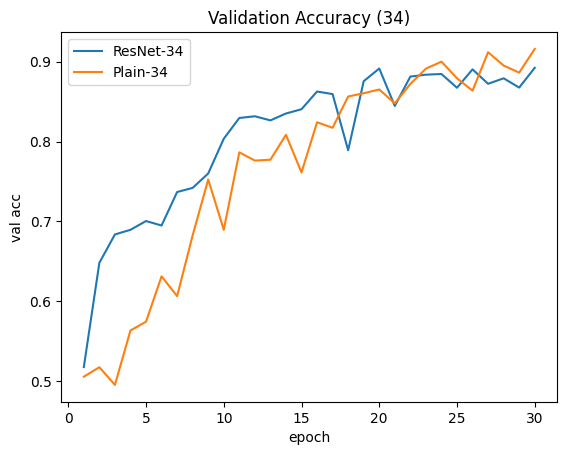

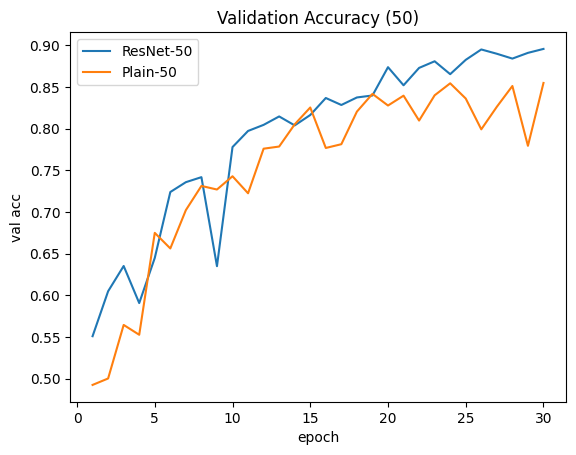

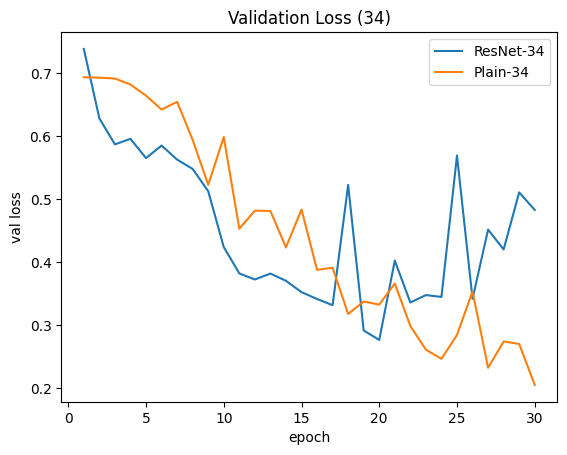

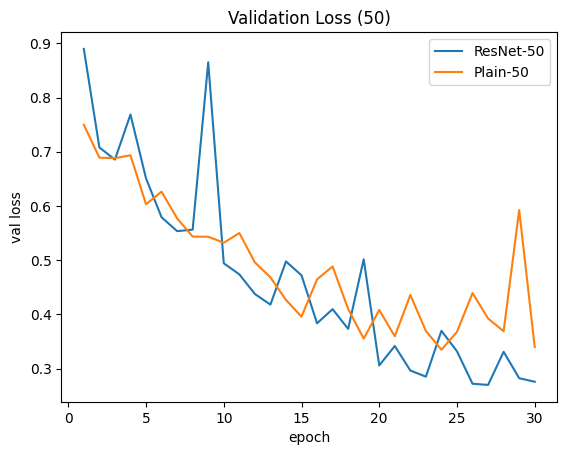

In [3]:
# ============================================================
# Full Script (cats_vs_dogs, 224x224)
# - num_workers autotune (+ fallback)
# - ResNet-34/50 vs Plain-34/50
# - torchsummary summaries, ablation table (CSV)
# ============================================================

import os, math, random, time, numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler
from torch.cuda.amp import autocast
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

# --------- summary (optional) ----------
try:
    from torchsummary import summary
    HAS_SUMMARY = True
except Exception:
    HAS_SUMMARY = False
    print("[Info] torchsummary not found. Install with: pip install torchsummary")

# ---------------- TFDS ----------------
import tensorflow_datasets as tfds
# (필요 시 링크 패치)
setattr(tfds.image_classification.cats_vs_dogs, '_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# ============================================================
# 0. Reproducibility
# ============================================================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(42)

# ============================================================
# 1. Models: ResNet Blocks, Plain Blocks, Builder
# ============================================================
class BasicBlock(nn.Module):
    """ResNet-18/34에서 사용하는 기본 블록(확장계수=1)
    - 3x3 conv → BN → ReLU → 3x3 conv → BN + (identity or downsample) → ReLU
    - stride>1이거나 채널 수가 바뀌면 downsample 경로로 skip을 맞춰줌
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        return self.relu(out + identity)

class Bottleneck(nn.Module):
    """ResNet-50/101/152에서 사용하는 병목 블록(확장계수=4)
    - 1x1으로 채널 축소 → 3x3 본연의 처리 → 1x1로 채널 확장(planes*4)
    - 연산/파라미터 효율을 높이면서 깊은 네트워크 구성 가능
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        mid = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(mid)
        self.conv2 = nn.Conv2d(mid, mid, 3, stride, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(mid)
        self.conv3 = nn.Conv2d(mid, out_channels * 4, 1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_channels * 4)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        return self.relu(out + identity)

# Plain (skip 없는) 버전
class PlainBasic(nn.Module):
    """ResNet BasicBlock과 conv 구성이 같지만 skip이 없는 버전."""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out)

class PlainBottle(nn.Module):
    """ResNet Bottleneck과 동일한 1x1-3x3-1x1 구조지만 skip이 없는 버전."""
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        mid = out_channels
        self.conv1 = nn.Conv2d(in_channels, mid, 1, bias=False); self.bn1=nn.BatchNorm2d(mid)
        self.conv2 = nn.Conv2d(mid, mid, 3, stride, 1, bias=False); self.bn2=nn.BatchNorm2d(mid)
        self.conv3 = nn.Conv2d(mid, out_channels*4, 1, bias=False); self.bn3=nn.BatchNorm2d(out_channels*4)
        self.relu  = nn.ReLU(inplace=True)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        return self.relu(out)

def make_stage(block_cls, inplanes, planes, num_blocks, stride, use_skip=True):
    """하나의 stage(layer1~4)를 생성.
    - block_cls: BasicBlock/Bottleneck 또는 PlainBasic/PlainBottle
    - inplanes: 입력 채널 수
    - planes: 블록의 기본 채널 수(Bottleneck일 경우 최종 out은 planes*expansion)
    - num_blocks: 블록 반복 횟수(예: [3,4,6,3])
    - stride: stage의 첫 블록에서만 적용되는 stride(해상도 downsample)
    - use_skip: True면 ResNet, False면 Plain
    반환: (nn.Sequential(stage), stage 출력 채널 수)
    """
    layers = []
    exp = getattr(block_cls, "expansion", 1)
    out_channels = planes * exp

    if use_skip:
        downsample = None
        if stride != 1 or inplanes != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers.append(block_cls(inplanes, planes, stride=stride, downsample=downsample))
    else:
        layers.append(block_cls(inplanes, planes, stride=stride))
    inplanes = out_channels

    for _ in range(1, num_blocks):
        layers.append(block_cls(inplanes, planes, stride=1))
    return nn.Sequential(*layers), inplanes

class AnyNet(nn.Module):
    """ResNet/Plain 공용 백본 빌더
    - stem: 7x7 conv, 3x3 maxpool
    - layer1~4: make_stage로 생성
    - head: GAP → FC(num_classes)
    """
    def __init__(self, block_cls, layers, num_classes, in_channels=3, use_skip=True):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(in_channels, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)

        self.layer1, self.inplanes = make_stage(block_cls, self.inplanes,  64, layers[0], 1, use_skip)
        self.layer2, self.inplanes = make_stage(block_cls, self.inplanes, 128, layers[1], 2, use_skip)
        self.layer3, self.inplanes = make_stage(block_cls, self.inplanes, 256, layers[2], 2, use_skip)
        self.layer4, self.inplanes = make_stage(block_cls, self.inplanes, 512, layers[3], 2, use_skip)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.inplanes, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4]:
            x = layer(x)
        x = self.avgpool(x); x = torch.flatten(x, 1)
        return self.fc(x)

def build_model(kind="resnet34", num_classes=2):
    """문자열 kind로 모델 종류 선택 생성.
    - resnet34/plain34: BasicBlock 기반, [3,4,6,3]
    - resnet50/plain50: Bottleneck 기반, [3,4,6,3]
    """
    if kind == "resnet34":
        return AnyNet(BasicBlock,  [3,4,6,3], num_classes, use_skip=True)
    if kind == "plain34":
        return AnyNet(PlainBasic,  [3,4,6,3], num_classes, use_skip=False)
    if kind == "resnet50":
        return AnyNet(Bottleneck,  [3,4,6,3], num_classes, use_skip=True)
    if kind == "plain50":
        return AnyNet(PlainBottle, [3,4,6,3], num_classes, use_skip=False)
    raise ValueError("kind must be one of: resnet34, plain34, resnet50, plain50")

# ============================================================
# 2. TFDS → PyTorch Dataset (TensorFlow 불필요)
# ============================================================
class TFDSNumpyDataset(Dataset):
    """tfds.as_numpy로 TFDS 샘플을 넘파이로 꺼내서 PIL+torchvision transform 수행
    - __getitem__은 (Tensor[C,H,W], int label)를 반환
    """
    def __init__(self, tfds_split, transform=None):
        self.samples = list(tfds.as_numpy(tfds_split))
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_np, label_np = self.samples[idx]  # (H,W,3), ()
        img = Image.fromarray(img_np)
        if self.transform:
            img = self.transform(img)
        return img, int(label_np)

# ============================================================
# 3. Transforms
# ============================================================
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.RandomResizedCrop(224, scale=(0.6, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
val_tf = T.Compose([
    T.Resize(256), T.CenterCrop(224),
    T.ToTensor(), T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# ============================================================
# 4. num_workers 자동 탐색 유틸 (DataLoader 안전 생성)
# ============================================================
def get_shm_gb():
    try:
        st = os.statvfs("/dev/shm")
        return (st.f_bavail * st.f_frsize) / (1024**3)
    except Exception:
        return None

def make_loader(dataset, batch_size=64, num_workers=0, shuffle=True, gpu=False, persistent=False):
    """DataLoader 생성기(안전 파라미터)
    - num_workers>0일 때만 pin_memory/prefetch_factor/persistent_workers 설정
    - gpu=True이면 pin_memory를 활성화해 H2D 전송 최적화
    """
    kwargs = dict(batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    if num_workers > 0:
        kwargs.update(dict(pin_memory=gpu, prefetch_factor=2, persistent_workers=persistent))
    else:
        kwargs.update(dict(pin_memory=False))
    return DataLoader(dataset, **kwargs)

@torch.no_grad()
def dry_run_throughput(loader, max_batches=60):
    t0 = time.time(); n = 0
    for i, (x, y) in enumerate(loader):
        n += x.size(0)
        if i+1 >= max_batches: break
    dt = time.time() - t0
    return 0.0 if dt == 0 else n / dt  # samples/sec

def autotune_num_workers(dataset, batch_size=64, gpu=False):
    cpu = os.cpu_count() or 2
    shm = get_shm_gb()
    candidates = [0, 2, 4, 8]
    if cpu > 8: candidates.append(16)
    if shm is not None and shm < 1.0:
        candidates = [0, 2, 4]

    best, best_tput = 0, -1
    for w in candidates:
        try:
            loader = make_loader(dataset, batch_size=batch_size, num_workers=w, shuffle=True, gpu=gpu, persistent=True)
            tput = dry_run_throughput(loader, max_batches=30)
            if tput > best_tput and tput > 0:
                best_tput, best = tput, w
        except Exception:
            continue
    return best if best_tput >= 0 else 0

# ============================================================
# 5. Train/Eval
# ============================================================
def accuracy(logits, y): return (logits.argmax(1) == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler, device):
    """한 에폭 학습 루프
    - autocast: CUDA에서만 AMP 적용(호스트 CPU일 경우 비활성)
    - GradScaler: FP16 언더플로 방지용 스케일링
    - set_to_none=True: optimizer.zero_grad 성능 미세개선
    반환: (평균 loss, 평균 acc)
    """
    model.train(); total_loss = total_acc = n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)
            loss = F.cross_entropy(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs
    return total_loss/n, total_acc/n

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); total_loss = total_acc = n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x); loss = F.cross_entropy(logits, y)
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs
    return total_loss/n, total_acc/n

def fit(model, train_loader, val_loader, epochs=5, lr=0.05, wd=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov=True)
    steps = math.ceil(len(train_loader.dataset)/train_loader.batch_size)
    sched = CosineAnnealingLR(opt, T_max=epochs*steps)
    scaler = GradScaler(device.type)

    hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, scaler, device)
        va_loss, va_acc = evaluate(model, val_loader, device)
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)
        sched.step()
        print(f"[{ep:02d}] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f}")
    return hist

# ============================================================
# 6. Main
# ============================================================
if __name__ == "__main__":
    print("Downloading/Preparing TFDS cats_vs_dogs...")
    tf_train = tfds.load("cats_vs_dogs", split="train", shuffle_files=True, as_supervised=True)
    full_ds = TFDSNumpyDataset(tf_train, transform=None)  # transform은 아래에서 부여

    # split (8:2)
    n_val = int(0.2 * len(full_ds))
    n_train = len(full_ds) - n_val
    train_ds, val_ds = random_split(full_ds, [n_train, n_val])

    # transform 부여
    train_ds.dataset.transform = train_tf
    val_ds.dataset.transform   = val_tf

    # num_workers 자동 탐색
    gpu = torch.cuda.is_available()
    print(f"CPU cores: {os.cpu_count()}, GPU: {gpu}, /dev/shm ≈ {get_shm_gb()} GB")
    suggested_workers = autotune_num_workers(train_ds, batch_size=64, gpu=gpu)
    print(f"Auto-selected num_workers = {suggested_workers}")

    # 안전 폴백
    try:
        train_loader = make_loader(train_ds, batch_size=64, num_workers=suggested_workers, shuffle=True,  gpu=gpu, persistent=True)
        val_loader   = make_loader(val_ds,   batch_size=64, num_workers=suggested_workers, shuffle=False, gpu=gpu, persistent=True)
        _ = next(iter(train_loader))  # 드라이런
    except Exception as e:
        print(f"num_workers={suggested_workers} failed ({e}). Falling back to num_workers=0.")
        suggested_workers = 0
        train_loader = make_loader(train_ds, batch_size=64, num_workers=0, shuffle=True,  gpu=False, persistent=False)
        val_loader   = make_loader(val_ds,   batch_size=64, num_workers=0, shuffle=False, gpu=False, persistent=False)

    num_classes = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---------------- Summaries ----------------
    res34 = build_model("resnet34", num_classes=num_classes).to(device)
    if HAS_SUMMARY:
        print("\n=== Summary: ResNet-34 ===")
        summary(res34, (3, 224, 224))
    res50 = build_model("resnet50", num_classes=num_classes).to(device)
    if HAS_SUMMARY:
        print("\n=== Summary: ResNet-50 ===")
        summary(res50, (3, 224, 224))

    # ---------------- Train: ResNet-34 vs Plain-34 ----------------
    pl34  = build_model("plain34",  num_classes=num_classes).to(device)
    print("\n>>> Training ResNet-34")
    hist_r34 = fit(res34, train_loader, val_loader, epochs=30, lr=0.05)
    print("\n>>> Training Plain-34")
    hist_p34 = fit(pl34,  train_loader, val_loader, epochs=30, lr=0.05)

    # ---------------- Train: ResNet-50 vs Plain-50 ----------------
    pl50  = build_model("plain50",  num_classes=num_classes).to(device)
    print("\n>>> Training ResNet-50")
    hist_r50 = fit(res50, train_loader, val_loader, epochs=30, lr=0.05)
    print("\n>>> Training Plain-50")
    hist_p50 = fit(pl50,  train_loader, val_loader, epochs=30, lr=0.05)

    # ---------------- Ablation Table ----------------
    import pandas as pd
    results = {
        "Model": ["ResNet-34", "Plain-34", "ResNet-50", "Plain-50"],
        "Val Acc (last epoch)": [
            hist_r34["val_acc"][-1],
            hist_p34["val_acc"][-1],
            hist_r50["val_acc"][-1],
            hist_p50["val_acc"][-1],
        ],
        "Val Loss (last epoch)": [
            hist_r34["val_loss"][-1],
            hist_p34["val_loss"][-1],
            hist_r50["val_loss"][-1],
            hist_p50["val_loss"][-1],
        ],
        "Epochs": [len(hist_r34["val_acc"])]*4
    }
    df_results = pd.DataFrame(results)
    print("\n=== Ablation Results ===")
    print(df_results)
    df_results.to_csv("ablation_results.csv", index=False)
    print("Saved: ablation_results.csv")

    # ---------------- Plots ----------------
    ep = range(1, len(hist_r34["val_acc"])+1)
    plt.figure(); plt.plot(ep, hist_r34["val_acc"], label="ResNet-34"); plt.plot(ep, hist_p34["val_acc"], label="Plain-34")
    plt.xlabel("epoch"); plt.ylabel("val acc"); plt.title("Validation Accuracy (34)"); plt.legend(); plt.show()

    ep = range(1, len(hist_r50["val_acc"])+1)
    plt.figure(); plt.plot(ep, hist_r50["val_acc"], label="ResNet-50"); plt.plot(ep, hist_p50["val_acc"], label="Plain-50")
    plt.xlabel("epoch"); plt.ylabel("val acc"); plt.title("Validation Accuracy (50)"); plt.legend(); plt.show()

    # (선택) Loss 플롯
    ep = range(1, len(hist_r34["val_loss"])+1)
    plt.figure(); plt.plot(ep, hist_r34["val_loss"], label="ResNet-34"); plt.plot(ep, hist_p34["val_loss"], label="Plain-34")
    plt.xlabel("epoch"); plt.ylabel("val loss"); plt.title("Validation Loss (34)"); plt.legend(); plt.show()

    ep = range(1, len(hist_r50["val_loss"])+1)
    plt.figure(); plt.plot(ep, hist_r50["val_loss"], label="ResNet-50"); plt.plot(ep, hist_p50["val_loss"], label="Plain-50")
    plt.xlabel("epoch"); plt.ylabel("val loss"); plt.title("Validation Loss (50)"); plt.legend(); plt.show()
